In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgi
import pandas as pd

In [16]:
dataset_name = "email-eu"

H = xgi.load_xgi_data(dataset_name)

In [17]:
print(H)

Hypergraph named email-Eu with 1005 nodes and 235263 hyperedges


In [18]:
vals, counts = np.unique(
    [len(c) for c in xgi.connected_components(H)], return_counts=True
)
pd.DataFrame({"Component Size": vals, "Number": counts})

,Component Size,Number
0,1,19
1,986,1


In [19]:
xgi.unique_edge_sizes(H)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40]

In [20]:
def plot_distributions(
    H,
    node_bins=None,
    edge_bins=None,
    log_x1=True,
    log_y1=True,
    log_x2=True,
    log_y2=True,
):

    if node_bins is None:
        node_bins = int(H.num_nodes / 20)

    if edge_bins is None:
        s = H.edges.size
        edge_bins = int(s.max() - s.min())

    plt.figure(figsize=(8, 4))
    plt.subplot(121)

    h1 = H.nodes.degree.ashist(bins=node_bins, density=True, log_binning=log_x1)
    h2 = H.edges.size.ashist(bins=edge_bins, density=True, log_binning=log_x2)
    y1 = h1[h1.value > 0].value
    y2 = h2[h2.value > 0].value
    ymin = 0.95 * min(y1.min(), y2.min())
    ymax = 1.05 * max(y1.max(), y2.max())

    if log_x1 and log_y1:
        plt.loglog(h1["bin_center"], h1["value"], "ko", markersize=2)
    elif log_x1 and not log_y1:
        plt.semilogx(h1["bin_center"], h1["value"], "ko", markersize=2)
    elif not log_x1 and log_y1:
        plt.semilogy(h1["bin_center"], h1["value"], "ko", markersize=2)
    elif not log_x1 and not log_y1:
        plt.plot(h1["bin_center"], h1["value"], "ko", markersize=2)

    plt.title("Degree distribution")
    plt.xlabel(r"$k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.ylim([ymin, ymax])
    sns.despine()

    plt.subplot(122)

    if log_x2 and log_y2:
        plt.loglog(h2["bin_center"], h2["value"], "ko", markersize=2)
    elif log_x2 and not log_y2:
        plt.semilogx(h2["bin_center"], h2["value"], "ko", markersize=2)
    elif not log_x2 and log_y2:
        plt.semilogy(h2["bin_center"], h2["value"], "ko", markersize=2)
    elif not log_x2 and not log_y2:
        plt.plot(h2["bin_center"], h2["value"], "ko", markersize=2)
    
    plt.title("Edge size distribution")
    plt.xlabel(r"$s$", fontsize=16)
    plt.ylabel(r"$P(s)$", fontsize=16)
    plt.ylim([ymin, ymax])
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"datasheets/{dataset_name}/stats.png", dpi=300)
    plt.show()

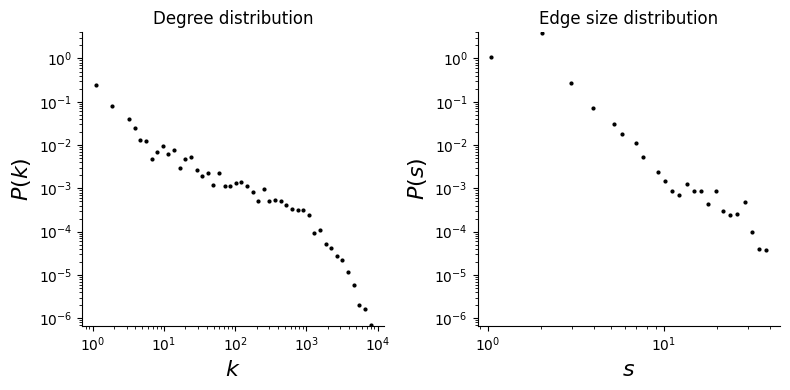

In [23]:
plot_distributions(H, log_x1=True, log_y1=True, log_x2=True, log_y2=True)